<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2021_0525semantic_segmentation_using_pytorch_deeplabv3_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Semantic Segmentation using PyTorch DeepLabV3 ResNet50](https://debuggercafe.com/semantic-segmentation-using-pytorch-deeplabv3-resnet50/)
![](https://debuggercafe.com/wp-content/uploads/2021/05/Semantic-Segmentation-using-PyTorch-DeepLabV3-ResNet50-e1620218415601.jpg)

In [ ]:
!mkdir outputs

## Download and Extract Input Test Data

In [ ]:
import requests
url = "https://drive.google.com/uc?id=1gFTRCjaI6IQ_g3Vr7oOa29gnLwsWhcAN&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
   f.write(r.content)

In [ ]:
!unzip input.zip

## Label Color Map Script

In [12]:
#%%writefile label_color_map.py
label_color_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

label_map = label_color_map

## Segmentation Utils

In [3]:
#%%writefile segmentation_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch

#from label_color_map import label_color_map as label_map

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def get_segment_labels(image, model, device):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)
    return outputs

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()

    # create Numpy arrays containing zeros
    # later to be used to fill them with respective red, green, and blue pixels
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 0]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 2]
        
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

def image_overlay(image, segmented_image):
    alpha = 1 # transparency for the original image
    beta = 0.8 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    return image

## Semantic Segmentation in Images

In [4]:
!ls *jpg

IMG_4056.jpg


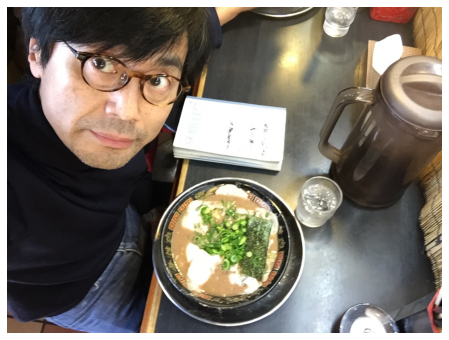

In [7]:
import matplotlib.pyplot as plt
import japanize_matplotlib

img_filename='IMG_4056.jpg'
img = plt.imread(img_filename)
plt.figure(figsize=(8,6))
plt.axis('off')
plt.imshow(img)

In [14]:
#%%writefile segment_image.py
import torchvision
import torch
import argparse
#import segmentation_utils
import cv2

from PIL import Image

# # construct the argument parser
# parser = argparse.ArgumentParser()
# parser.add_argument('-i', '--input', help='path to input image')
# args = vars(parser.parse_args())



# set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# download or load the model from disk
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
# model to eval() model and load onto computation devicce
model.eval().to(device)

# read the image
#image = Image.open(args['input'])
image = Image.open(img_filename)
# do forward pass and get the output dictionary
#outputs = segmentation_utils.get_segment_labels(image, model, device)
outputs = get_segment_labels(image, model, device)
# get the data from the `out` key
outputs = outputs['out']
#segmented_image = segmentation_utils.draw_segmentation_map(outputs)
segmented_image = draw_segmentation_map(outputs)

#final_image = segmentation_utils.image_overlay(image, segmented_image)
final_image = image_overlay(image, segmented_image)
#save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
save_filename = 'img_semantic_segmented.jpg'
# show the segmented image and save to disk
# cv2.imshow('Segmented image', final_image)
# cv2.waitKey(0)
#cv2.imwrite(f"outputs/{save_name}.jpg", final_image)
cv2.imwrite(save_filename, final_image)

True

In [ ]:
#!python segment_image.py --input input/image_1.jpg

In [15]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 12, 9

In [16]:
#!ls outputs

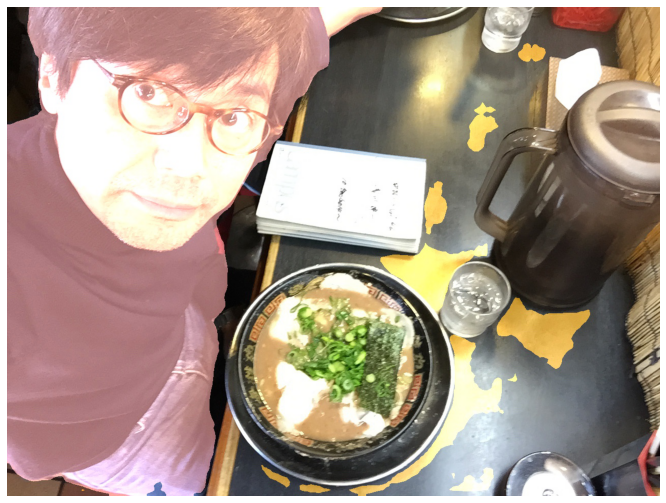

In [17]:
img_filename = 'img_semantic_segmented.jpg'
#image = plt.imread('outputs/image_1.jpg')
image = plt.imread(img_filename)
plt.imshow(image)
plt.axis('off')
plt.show()

In [18]:
#!python segment_image.py --input input/image_2.jpg

In [19]:
#image = plt.imread('outputs/image_2.jpg')
#plt.imshow(image)
#plt.axis('off')
#plt.show()

## Semantic Segmentation in Videos

In [ ]:
%%writefile segment_video.py
import torchvision
import cv2
import torch
import argparse
import time
import segmentation_utils

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input video')
args = vars(parser.parse_args())

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# download or load the model from disk
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
# load the model onto the computation device
model = model.eval().to(device)

cap = cv2.VideoCapture(args['input'])
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"outputs/{save_name}.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))

frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # get the start time
        start_time = time.time()
        with torch.no_grad():
            # get predictions for the current frame
            outputs = segmentation_utils.get_segment_labels(rgb_frame, model, device)
        
        # obtain the segmentation map
        segmented_image = segmentation_utils.draw_segmentation_map(outputs['out'])
        # get the final image with segmentation map overlayed on original iimage
        final_image = segmentation_utils.image_overlay(rgb_frame, segmented_image)

        # get the end time
        end_time = time.time()
        # get the current fps
        fps = 1 / (end_time - start_time)
        # add current fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        print(f"Frame: {frame_count}, FPS: {fps:.3f}")
        # put the FPS text on the current frame
        cv2.putText(final_image, f"{fps:.3f} FPS", (20, 35), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # press `q` to exit
        # cv2.imshow('image', final_image)
        out.write(final_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

In [ ]:
!python segment_video.py --input input/video_1.mp4

### <font color="orange">To visualize all the outputs, you can zip the `outputs` folders and download it to your system.</font>

In [ ]:
!zip -r /content/outputs outputs

In [ ]:
from google.colab import files

files.download('/content/outputs.zip')